In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action= 'ignore', category = FutureWarning)
%matplotlib inline

In [2]:
os.chdir('D:/deep learning/data/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makesdirs('train/dog')
    os.makesdirs('train/cat')
    os.makesdirs('valid/dog')
    os.makesdirs('valid/cat')
    os.makesdirs('test/dog')
    os.makesdirs('test/cat')
    
    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c, 'test/dog')
        
os.chdir('../../')
    

In [3]:
train_path = 'D:/deep learning/data/dogs-vs-cats/train'
valid_path = 'D:/deep learning/data/dogs-vs-cats/valid'
test_path = 'D:/deep learning/data/dogs-vs-cats/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory= test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle = False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
imgs, labels = next(train_batches)


In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,5, figsize =(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


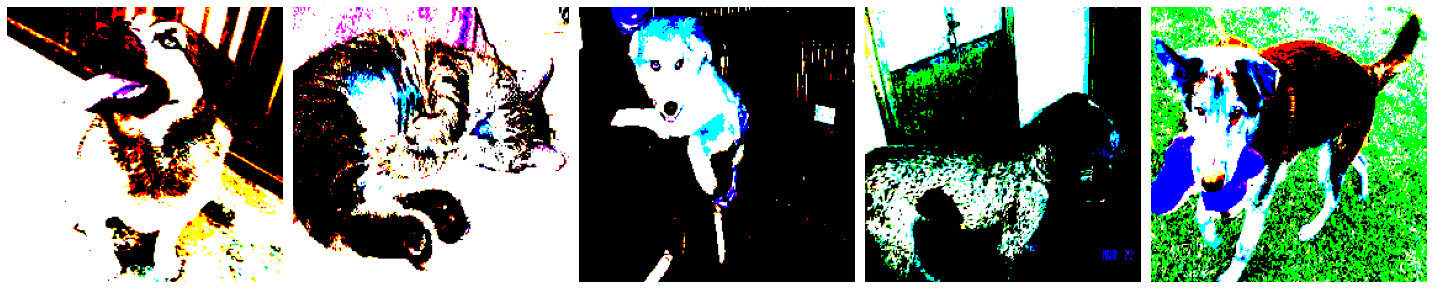

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [7]:
plotImages(imgs)
print(labels)

In [8]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [9]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
type(vgg16_model)

keras.engine.functional.Functional

In [12]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [14]:
for layer in model.layers:
    layer.trainable= False

In [15]:
model.add(Dense(units = 2, activation = 'softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [17]:
model.compile(optimizer= Adam(learning_rate= 0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])
model.fit?

In [18]:
model.fit(x=train_batches, validation_data = valid_batches, epochs=5, verbose= 2)

Epoch 1/5
100/100 - 119s - loss: 0.4464 - accuracy: 0.8220 - val_loss: 0.0864 - val_accuracy: 0.9550 - 119s/epoch - 1s/step
Epoch 2/5
100/100 - 117s - loss: 0.1130 - accuracy: 0.9670 - val_loss: 0.0475 - val_accuracy: 0.9900 - 117s/epoch - 1s/step
Epoch 3/5
100/100 - 132s - loss: 0.0767 - accuracy: 0.9760 - val_loss: 0.0359 - val_accuracy: 0.9900 - 132s/epoch - 1s/step
Epoch 4/5
100/100 - 131s - loss: 0.0566 - accuracy: 0.9850 - val_loss: 0.0308 - val_accuracy: 0.9900 - 131s/epoch - 1s/step
Epoch 5/5
100/100 - 129s - loss: 0.0442 - accuracy: 0.9900 - val_loss: 0.0285 - val_accuracy: 0.9900 - 129s/epoch - 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


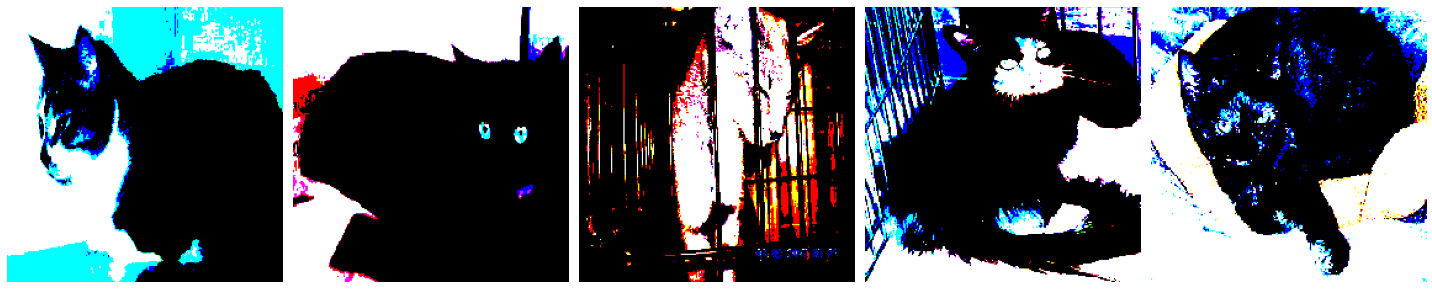

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:
test_imgs, test_labels = next (test_batches)
plotImages(test_imgs)
print(test_labels)

In [20]:
predictions = model.predict(x=test_batches, verbose=0)
rounded_prediction = np.argmax(predictions, axis= -1)

for i in rounded_prediction:
    print (i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1


In [21]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'confusion matrix', cmap= plt.cm.Blues):
    
    plt.imshow(cm, interpolation ='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes, rotation= 45)
    
    if normalize:
        cm = cm.astypes('float')/ cm.sum(axis=1)[:, np.newaxis]
        print("normalised confusion matrix")
    else:
        print('confusion matrix without normalisation')
    
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment = "center",
                color = "white" if cm[i, j ] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predictive label')
    
    
    

In [22]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred = np.argmax(predictions, axis= -1))

In [24]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
y_pred = np.argmax(predictions, axis= -1)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1]


confusion matrix without normalisation
[[48  2]
 [ 2 48]]


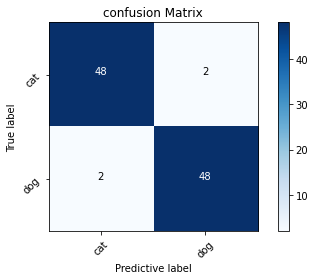

In [26]:
cm_plot_label = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes = cm_plot_label, title= 'confusion Matrix')  
    
    